# Rock, Paper, Scissors Dataset ML

This dataset was developed by Laurence Maroney and contains images of computer generated hands in positions corresponding to playing the game "rock, paper, scissors." The goal is to classify the images of the hands into "rock," "paper," or "scissors." More information on the dataset can be found <a href="https://laurencemoroney.com/datasets.html">here</a>.

## Imports

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

## Helper Functions

In [2]:
def plot_training_metrics(history):
    fig = plt.figure(facecolor=(1, 1, 1, 1), figsize=(12, 8)) # My notebook is in dark mode
    plt.subplot(1, 2, 1)
    plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.suptitle('Model Training')
    plt.legend()
    plt.show()

def save_best_model(model, test_ds, filename):
    try:
        saved_model = tf.keras.models.load_model(filename)
    except:
        saved_model = None

    if saved_model:
        print('Saved Model Evaluation:')
        saved_model_metrics = saved_model.evaluate(test_ds, return_dict=True)
        print('New Model Evaluation:')
        new_model_metrics = model.evaluate(test_ds, return_dict=True)
        if new_model_metrics['sparse_categorical_accuracy'] > saved_model_metrics['sparse_categorical_accuracy']:
            model.save(filename)
    else:
        model.save(filename)

## Loading the Dataset

This dataset comes in a train-test split. We further split the training set into both a training and validation set using an 80-20 split.

Number of Training Examples: 2016
Number of Validation Examples: 504
Number of Testing Examples: 372


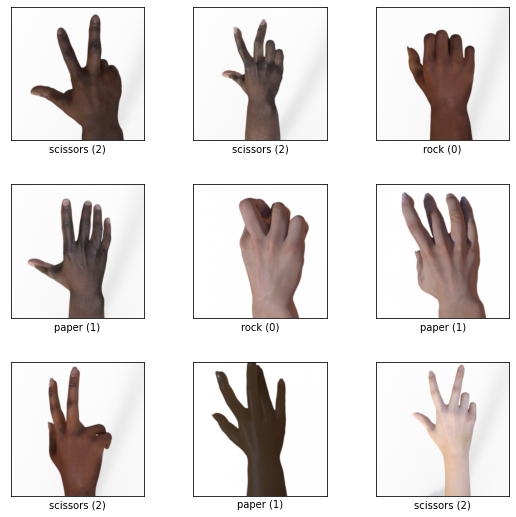

In [4]:
(train_ds, validation_ds, test_ds), ds_info = tfds.load('rock_paper_scissors', as_supervised=True, split=['train[:80%]', 'train[80%:]', 'test'], with_info=True)
num_testing_examples = test_ds.cardinality()
num_training_examples = train_ds.cardinality()
num_validation_examples = validation_ds.cardinality()
print(f'Number of Training Examples: {num_training_examples}')
print(f'Number of Validation Examples: {num_validation_examples}')
print(f'Number of Testing Examples: {num_testing_examples}')
fig = tfds.show_examples(train_ds, ds_info)

## Preparing the Data

In [5]:
def normalize_images(image, label):
    return tf.cast(image, tf.float32), label

batch_size = 16

AUTOTUNE = tf.data.AUTOTUNE

test_ds = test_ds.map(normalize_images, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(batch_size)
test_ds = test_ds.prefetch(AUTOTUNE)

train_ds = train_ds.map(normalize_images, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.shuffle(num_training_examples)
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(AUTOTUNE)

validation_ds = validation_ds.map(normalize_images, num_parallel_calls=AUTOTUNE)
validation_ds = validation_ds.batch(batch_size)
validation_ds = validation_ds.prefetch(AUTOTUNE)

## Building a Model

In [34]:
# Best Model
# model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(64, 8, activation='relu', input_shape=(300, 300, 3)),
#     tf.keras.layers.MaxPool2D(),
#     tf.keras.layers.Conv2D(32, 8, activation='relu'),
#     tf.keras.layers.MaxPool2D(),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(3)
# ])

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, 8, activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(32, 8, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(16, 8, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3)
])
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    optimizer=tf.keras.optimizers.Adam(5e-6)
)
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 293, 293, 64)      12352     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 146, 146, 64)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 139, 139, 32)      131104    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 69, 69, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 62, 62, 16)        32784     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 31, 31, 16)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 15376)            

## Training the Model and Saving if Better than Our Best Model

In [35]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    mode='max',
    monitor='val_sparse_categorical_accuracy',
    patience=3,
    restore_best_weights=True
)
history = model.fit(train_ds, callbacks=[early_stopping_callback], epochs=100, validation_data=validation_ds)

Epoch 1/100
126/126 [==============================] - 16s 117ms/step - loss: 12.1991 - sparse_categorical_accuracy: 0.4335 - val_loss: 1.1280 - val_sparse_categorical_accuracy: 0.6825
Epoch 2/100
126/126 [==============================] - 15s 116ms/step - loss: 1.5118 - sparse_categorical_accuracy: 0.6875 - val_loss: 0.3778 - val_sparse_categorical_accuracy: 0.8790
Epoch 3/100
126/126 [==============================] - 15s 115ms/step - loss: 0.5399 - sparse_categorical_accuracy: 0.8462 - val_loss: 0.1539 - val_sparse_categorical_accuracy: 0.9544
Epoch 4/100
126/126 [==============================] - 15s 118ms/step - loss: 0.2828 - sparse_categorical_accuracy: 0.9097 - val_loss: 0.0720 - val_sparse_categorical_accuracy: 0.9861
Epoch 5/100
126/126 [==============================] - 15s 117ms/step - loss: 0.1858 - sparse_categorical_accuracy: 0.9420 - val_loss: 0.0557 - val_sparse_categorical_accuracy: 0.9821
Epoch 6/100
126/126 [==============================] - 15s 117ms/step - loss: 0

## Plotting Training Metrics

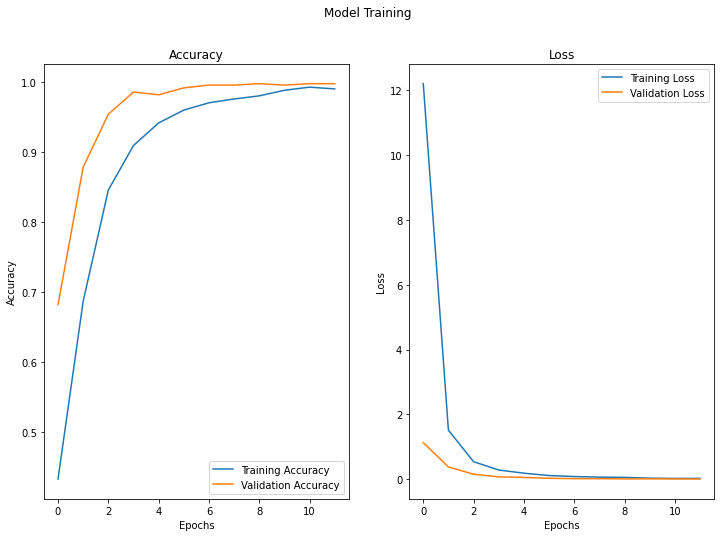

In [38]:
plot_training_metrics(history)

## Saving the Best Model

In [39]:
save_best_model(model, test_ds, 'models\\CNN')

Saved Model Evaluation:
24/24 [==============================] - 1s 25ms/step - loss: 1.0891 - sparse_categorical_accuracy: 0.7823
New Model Evaluation:
24/24 [==============================] - 1s 24ms/step - loss: 1.3978 - sparse_categorical_accuracy: 0.6882


As can be seen above, the best model currently achieves 78.23% accuracy

## Testing How Image Augmentation Changes Our Results

### Reloading the Data and Applying Augmentation

Found 2016 images belonging to 3 classes.
Found 504 images belonging to 3 classes.


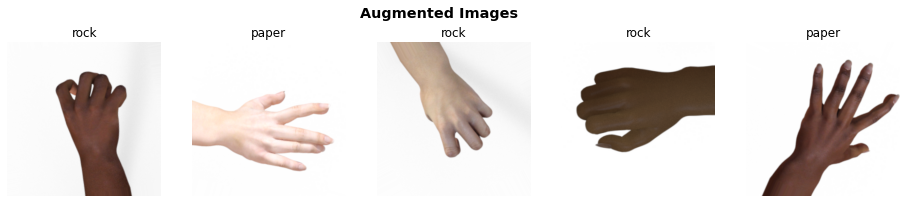

In [6]:
with open('secrets.json') as f:
    secrets = json.load(f)
    path_to_train_ds = secrets['path_to_train_ds']

image_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    rescale=1/255,
    rotation_range=360,
    validation_split=0.2,
    vertical_flip=True
)

batch_size = 16
image_size = (300, 300)

train_gen = image_gen.flow_from_directory(path_to_train_ds, batch_size=batch_size, class_mode='sparse', subset='training', target_size=image_size)
validation_gen = image_gen.flow_from_directory(path_to_train_ds, batch_size=batch_size, class_mode='sparse', subset='validation', target_size=image_size)

preview_batch = train_gen.next()
ind2name = {value:key for key, value in train_gen.class_indices.items()}
fig = plt.figure(facecolor=(1, 1, 1, 1), figsize=(16, 16)) # My notebook is in dark mode
fig.suptitle('Augmented Images', fontsize='x-large', fontweight='semibold', y=0.6)
for i in range(5):
    image = preview_batch[0][i, :, :, :]
    image = np.squeeze(image)
    label = preview_batch[1][i]
    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(ind2name[label])
plt.show()

### Building a New Model

In [7]:
augmented_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, 5, activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(32, 5, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3)
])
augmented_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    optimizer=tf.keras.optimizers.Adam(5e-6)
)
augmented_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 296, 296, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 148, 148, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 144, 144, 32)      51232     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 72, 72, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 165888)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               42467584  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0

### Training the New Model

In [8]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    mode='max',
    monitor='val_sparse_categorical_accuracy',
    patience=5,
    restore_best_weights=True
)
augmented_history = augmented_model.fit(train_gen, callbacks=[early_stopping_callback], epochs=100, validation_data=validation_gen)

Epoch 1/100
252/252 [==============================] - 45s 167ms/step - loss: 1.1149 - sparse_categorical_accuracy: 0.3785 - val_loss: 1.1069 - val_sparse_categorical_accuracy: 0.3651
Epoch 2/100
252/252 [==============================] - 41s 163ms/step - loss: 1.0849 - sparse_categorical_accuracy: 0.4013 - val_loss: 1.1098 - val_sparse_categorical_accuracy: 0.4821
Epoch 3/100
252/252 [==============================] - 41s 164ms/step - loss: 1.0336 - sparse_categorical_accuracy: 0.4618 - val_loss: 1.0742 - val_sparse_categorical_accuracy: 0.3968
Epoch 4/100
252/252 [==============================] - 41s 163ms/step - loss: 0.9740 - sparse_categorical_accuracy: 0.5238 - val_loss: 1.0237 - val_sparse_categorical_accuracy: 0.3909
Epoch 5/100
252/252 [==============================] - 41s 164ms/step - loss: 0.9116 - sparse_categorical_accuracy: 0.5868 - val_loss: 0.9830 - val_sparse_categorical_accuracy: 0.4802
Epoch 6/100
252/252 [==============================] - 41s 164ms/step - loss: 0.

### Plotting Training Metrics

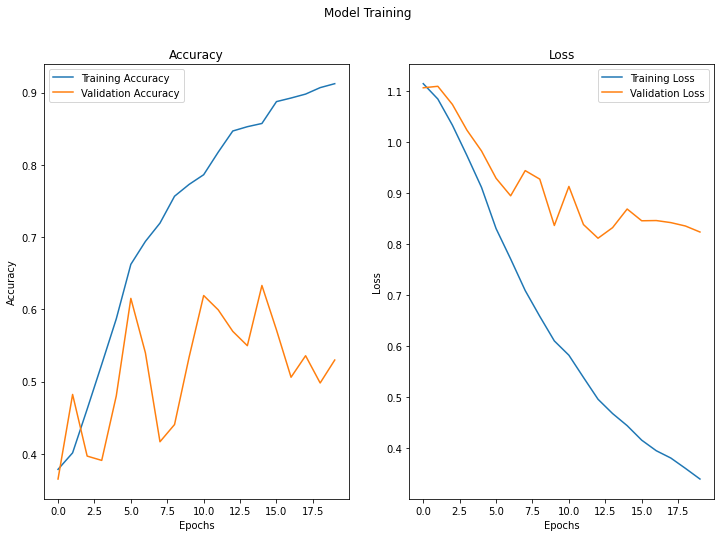

In [9]:
plot_training_metrics(augmented_history)

### Saving our Best Model

The same test dataset as before is used here to enable an apples to apples comparison of the models

In [10]:
save_best_model(augmented_model, test_ds, 'models\\Augmented_CNN')

Saved Model Evaluation:
24/24 [==============================] - 2s 36ms/step - loss: 222.2586 - sparse_categorical_accuracy: 0.3602
New Model Evaluation:
24/24 [==============================] - 1s 29ms/step - loss: 441.5962 - sparse_categorical_accuracy: 0.3118


As can be seen above, the best model currently achieves a miserable 36.02% accuracy, not significantly better than guessing (which would give 33.33%). This indicates that classifying the augmented images is a significantly harder problem. Our testing scheme is also biased towards the normal (not augmented) model since it is both trained and tested on normal images while the augmented model is trained on augmented images then tested on normal images. Normal images are a subset of the images that the augmented model would be expected to classify, but the different circumstances of training and testing make the task more difficult for the augmented model.

## Transfer Learning Approach

For transfer learning we use the Inception V3 model from tensorflow hub.

In [3]:
feature_extractor_model = 'https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4'
feature_extractor_input_shape = (224, 224, 3)
feature_extractor_layer = hub.KerasLayer(feature_extractor_model, input_shape=feature_extractor_input_shape, trainable=False)

To accomodate Inception V3 being trained on 224 x 224 images we must reshape our dataset.

In [6]:
def normalize_and_resize_image(image, label):
    image = tf.image.resize(image, [feature_extractor_input_shape[0], feature_extractor_input_shape[1]])
    image = image/255
    return image, label

In [7]:
(transfer_train_ds, transfer_validation_ds, transfer_test_ds), ds_info = tfds.load('rock_paper_scissors', as_supervised=True, split=['train[:80%]', 'train[80%:]', 'test'], with_info=True)

AUTOTUNE = tf.data.AUTOTUNE
batch_size = 16

transfer_test_ds = transfer_test_ds.map(normalize_and_resize_image, num_parallel_calls=AUTOTUNE)
transfer_test_ds = transfer_test_ds.cache()
transfer_test_ds = transfer_test_ds.batch(batch_size)
transfer_test_ds = transfer_test_ds.prefetch(AUTOTUNE)

transfer_train_ds = transfer_train_ds.map(normalize_and_resize_image, num_parallel_calls=AUTOTUNE)
transfer_train_ds = transfer_train_ds.cache()
transfer_train_ds = transfer_train_ds.batch(batch_size)
transfer_train_ds = transfer_train_ds.prefetch(AUTOTUNE)

transfer_validation_ds = transfer_validation_ds.map(normalize_and_resize_image, num_parallel_calls=AUTOTUNE)
transfer_validation_ds = transfer_validation_ds.cache()
transfer_validation_ds = transfer_validation_ds.batch(batch_size)
transfer_validation_ds = transfer_validation_ds.prefetch(AUTOTUNE)

### Creating the Transfer Learning Model

In [60]:
transfer_model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3)
])
transfer_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    optimizer=tf.keras.optimizers.Adam(5e-6)
)
transfer_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dense_26 (Dense)             (None, 256)               524544    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 3)                 387       
Total params: 22,360,611
Trainable params: 557,827
Non-trainable params: 21,802,784
___________________________________

### Training the Transfer Model

In [61]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    mode='max',
    monitor='val_sparse_categorical_accuracy',
    patience=3,
    restore_best_weights=True
)
transfer_history = transfer_model.fit(transfer_train_ds, callbacks=[early_stopping_callback], epochs=100, validation_data=transfer_validation_ds)

Epoch 1/100
126/126 [==============================] - 10s 64ms/step - loss: 1.2137 - sparse_categorical_accuracy: 0.4038 - val_loss: 0.9614 - val_sparse_categorical_accuracy: 0.6210
Epoch 2/100
126/126 [==============================] - 7s 58ms/step - loss: 0.9940 - sparse_categorical_accuracy: 0.5089 - val_loss: 0.7986 - val_sparse_categorical_accuracy: 0.8552
Epoch 3/100
126/126 [==============================] - 7s 59ms/step - loss: 0.8341 - sparse_categorical_accuracy: 0.6314 - val_loss: 0.6636 - val_sparse_categorical_accuracy: 0.9206
Epoch 4/100
126/126 [==============================] - 7s 59ms/step - loss: 0.7242 - sparse_categorical_accuracy: 0.7237 - val_loss: 0.5585 - val_sparse_categorical_accuracy: 0.9345
Epoch 5/100
126/126 [==============================] - 7s 59ms/step - loss: 0.6447 - sparse_categorical_accuracy: 0.7684 - val_loss: 0.4789 - val_sparse_categorical_accuracy: 0.9464
Epoch 6/100
126/126 [==============================] - 7s 59ms/step - loss: 0.5782 - spar

### Plotting Training Metrics

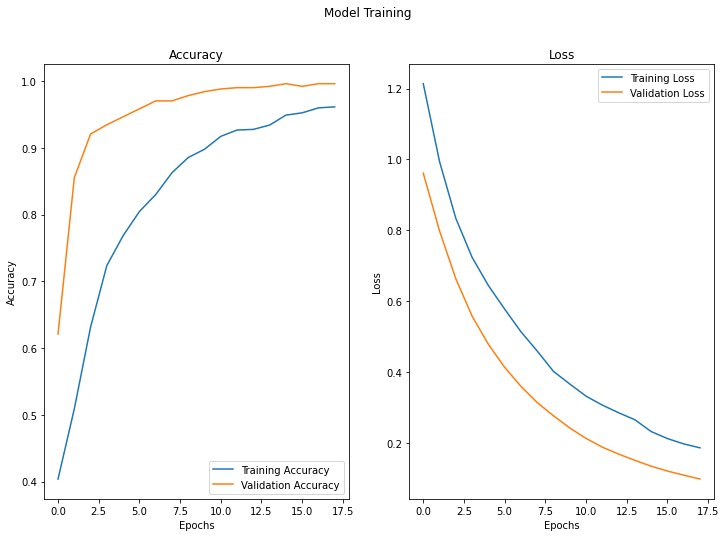

In [62]:
plot_training_metrics(transfer_history)

### Saving the Best Transfer Model

Note that transfer_test_ds is simply a resized version of test_ds, so this is still an apples-to-apples comparison with the other models

In [63]:
save_best_model(transfer_model, transfer_test_ds, 'models\\Transfer_Model')

Saved Model Evaluation:
24/24 [==============================] - 2s 45ms/step - loss: 0.6479 - sparse_categorical_accuracy: 0.6747
New Model Evaluation:
24/24 [==============================] - 1s 44ms/step - loss: 0.5941 - sparse_categorical_accuracy: 0.7177
INFO:tensorflow:Assets written to: Transfer_Model\assets


INFO:tensorflow:Assets written to: Transfer_Model\assets


Interestingly, this is only slightly better than our earlier custom model.

## Transfer Learning on Augmented Images

In [13]:
with open('secrets.json') as f:
    secrets = json.load(f)
    path_to_train_ds = secrets['path_to_train_ds']

transfer_image_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    rescale=1/255,
    rotation_range=360,
    validation_split=0.2,
    vertical_flip=True
)

batch_size = 16
image_size = (224, 224)

transfer_train_gen = transfer_image_gen.flow_from_directory(path_to_train_ds, batch_size=batch_size, class_mode='sparse', subset='training', target_size=image_size)
transfer_validation_gen = transfer_image_gen.flow_from_directory(path_to_train_ds, batch_size=batch_size, class_mode='sparse', subset='validation', target_size=image_size)

Found 2016 images belonging to 3 classes.
Found 504 images belonging to 3 classes.


### Creating the Augmented Transfer Model

In [56]:
# Best Model
# augmented_transfer_model = tf.keras.Sequential([
#     feature_extractor_layer,
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(3)
# ])

augmented_transfer_model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3)
])
augmented_transfer_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    optimizer=tf.keras.optimizers.Adam(1e-5)
)
augmented_transfer_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dense_23 (Dense)             (None, 256)               524544    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_25 (Dense)             (None, 3)                 387       
Total params: 22,360,611
Trainable params: 557,827
Non-trainable params: 21,802,784
_________________________________________________________________


### Training the Augmented Transfer Model

In [57]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    mode='max',
    monitor='val_sparse_categorical_accuracy',
    patience=3,
    restore_best_weights=True
)
augmented_transfer_history = augmented_transfer_model.fit(transfer_validation_gen, callbacks=[early_stopping_callback], epochs=100, validation_data=transfer_validation_gen)

Epoch 1/100
32/32 [==============================] - 13s 366ms/step - loss: 1.4443 - sparse_categorical_accuracy: 0.3452 - val_loss: 1.1754 - val_sparse_categorical_accuracy: 0.3829
Epoch 2/100
32/32 [==============================] - 11s 348ms/step - loss: 1.1884 - sparse_categorical_accuracy: 0.3452 - val_loss: 1.0605 - val_sparse_categorical_accuracy: 0.4127
Epoch 3/100
32/32 [==============================] - 11s 336ms/step - loss: 1.0592 - sparse_categorical_accuracy: 0.4167 - val_loss: 0.9991 - val_sparse_categorical_accuracy: 0.4921
Epoch 4/100
32/32 [==============================] - 11s 337ms/step - loss: 0.9897 - sparse_categorical_accuracy: 0.5099 - val_loss: 0.9297 - val_sparse_categorical_accuracy: 0.6230
Epoch 5/100
32/32 [==============================] - 11s 336ms/step - loss: 0.9801 - sparse_categorical_accuracy: 0.5298 - val_loss: 0.8829 - val_sparse_categorical_accuracy: 0.6210
Epoch 6/100
32/32 [==============================] - 11s 338ms/step - loss: 0.8951 - spars

### Plotting Training Metrics

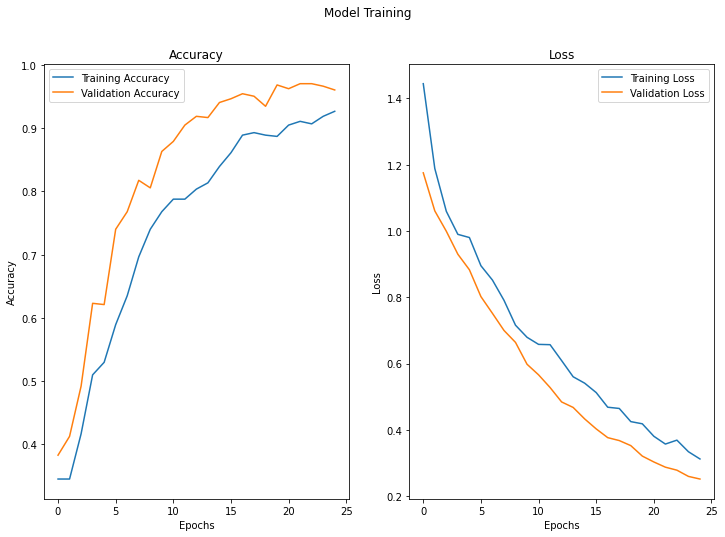

In [58]:
plot_training_metrics(augmented_transfer_history)

### Saving the Best Model

In [59]:
save_best_model(augmented_transfer_model, transfer_test_ds, 'models\\Augmented_Transfer_Model')

Saved Model Evaluation:
24/24 [==============================] - 2s 47ms/step - loss: 1.1740 - sparse_categorical_accuracy: 0.5242
New Model Evaluation:
24/24 [==============================] - 2s 46ms/step - loss: 1.1681 - sparse_categorical_accuracy: 0.4543


Transfer learning shows good improvement over the earlier custom model here, now achieving an accuracy that is significantly better than guessing (although still leaving something to be desired)